# Acoustic complexity index

This notebook calculates the acoustic complexity index (ACI) as defined in Pieretti, et al. 2011. The ACI is based on the "observation that many biotic sounds, such as bird songs, are char- acterized by an intrinsic variability of intensities, while some types of human generated noise (such as car passing or airplane transit) present very constant intensity values. (Pieretti, et al. 2011)."

Pieretti, N., A. Farina, and D. Morri. 2011. A new methodology to infer the singing activity of an avian community: The Acoustic Complexity Index (ACI). Ecological Indicators 11: 868-873. doi: 10.1016/j.ecolind.2010.11.005

#### Required packages

[numpy](https://github.com/numpy/numpy) <br />
[numba](https://github.com/numba/numba) <br />
[nacoustik](https://github.com/jacobdein/nacoustik) <br />
[matplotlib](https://github.com/matplotlib/matplotlib)

#### Import statements

In [1]:
import numpy as np
from numba import guvectorize, float64
from nacoustik import Wave
from nacoustik.noise import remove_background_noise
from nacoustik.spectrum import psd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = "/Users/Jake/Desktop/seewave_examples/160317-145000_24k.wav"

## Compute spectrogram

In [3]:
sound = Wave(filepath)
sound.read()
sound.normalize()
# trim sound to first 20 seconds
sound.samples = sound.samples[0:480000, :]
sound.n_samples = 480000

f, t, a = psd(sound)

## Plot spectrogram

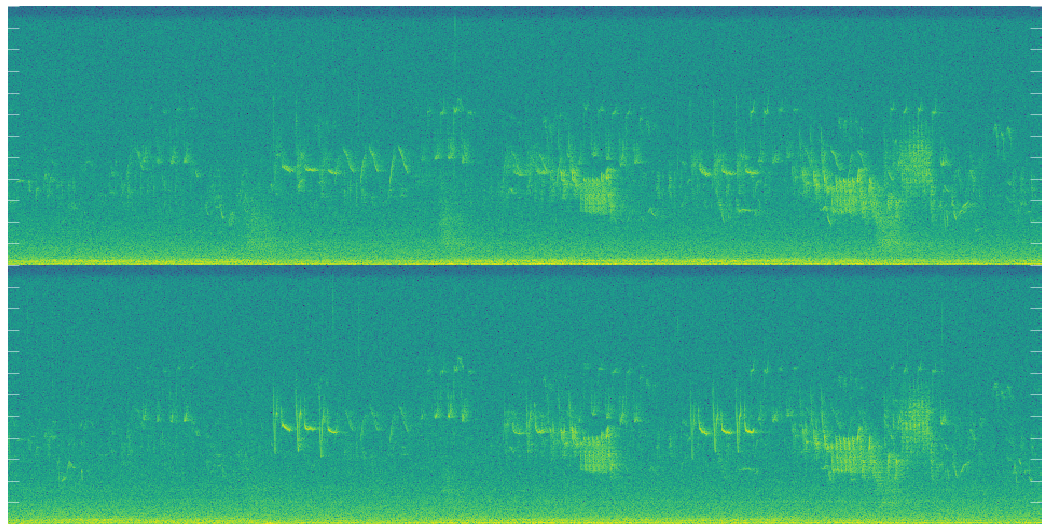

In [4]:
# figure configuration
dpi = 192
channels = sound.n_channels
fig, ax = plt.subplots(channels, 1)
fig.set_dpi(dpi)
fig.set_figwidth((920 / dpi) * 3)
fig.set_figheight((460 / dpi) * 3)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.set_frameon(False)

# specify frequency bins (width of 1 kiloherz)
bins = np.arange(0, (sound.rate / 2), 1000)

# plot spectrogram for each channel
for channel in range(channels):
    spec = ax[channel].pcolormesh(t, f, a[channel], cmap='viridis')
    ax[channel].set(ylim=([0, sound.rate / 2]),
                  yticks = bins.astype(np.int) + 1000)
    ax[channel].tick_params(length=12, color='white',
                          bottom=False, labelbottom=False,
                          top=False, labeltop=False,
                          labelleft=False,
                          labelright=False)
    ax[channel].set_frame_on(False)

## Implement the algorithm to compute the ACI

returns the ACI for each frequency band for each channel <br />
implemented as a universal function via numba.guvectorize

In [5]:
@guvectorize([(float64[:,:,:], float64[:], float64[:], float64[:,:])], 
             '(c,f,t),(),()->(c,f)', nopython=True)
def calculate_aci(a, time_delta, block_duration, aci):
    block_delta = int(np.around(block_duration[0] / time_delta[0]))
    n_blocks = int(np.floor(a.shape[2] / block_delta))
    remainder = int(a.shape[2] - (block_delta * n_blocks))
    for channel in range(a.shape[0]):
        for f_band in range(a.shape[1]):
            aci_f_band = np.empty(shape=(n_blocks + 1))
            for block in range(n_blocks):
                d = np.empty(shape=(block_delta - 1))
                for t_step in range(block_delta - 1):
                    d[t_step] = np.abs(a[channel, f_band, (t_step * (block + 1))] - \
                                       a[channel, f_band, ((t_step * (block + 1)) + 1)])
                D = d.sum()
                aci_f_band[block] = D / a[channel, f_band, \
                                          (block_delta * block):(block_delta * (block + 1))].sum()
            if remainder > 1:
                d = np.empty(shape=(remainder - 1))
                for t_step in range(remainder - 1):
                    d[t_step] = np.abs(a[channel, f_band, ((t_step * n_blocks) + t_step)] - \
                                       a[channel, f_band, ((t_step * n_blocks) + t_step + 1)])
                D = d.sum()
                aci_f_band[-1] = D / a[channel, f_band, -(remainder + 1):-1].sum()
            # average aci value over blocks
            aci[channel, f_band] = aci_f_band.sum() / (n_blocks + (remainder / block_delta))

## Compute ACI

convert the spectrogram values to watts before computing the ACI

In [6]:
aci = calculate_aci(10**(a / 10), 
                    (t[1] - t[0]),
                    5.,
                    np.empty(shape=(a.shape[0], a.shape[1])))

## Plot the ACI

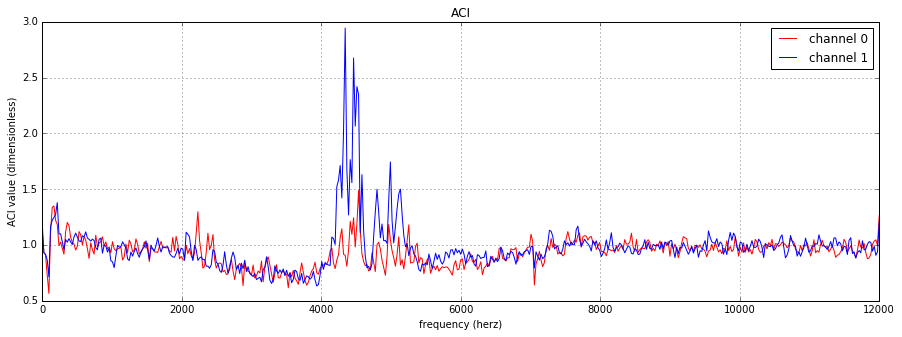

In [7]:
colors = ['red', 'blue']
fig, ax = plt.subplots(figsize=(15, 5))
for channel in range(aci.shape[0]):
    p = plt.plot(f, aci[channel], color=colors[channel], 
                 label="channel {0}".format(channel))
title = ax.set_title('ACI')
xlabel = ax.set_xlabel('frequency (herz)')
ylabel = ax.set_ylabel('ACI value (dimensionless)')
legend = ax.legend()
ax.grid(True, which='major')

## Compute and plot the ACI after background noise removal

remove background noise

In [8]:
ale = remove_background_noise(a, iterations=5)

plot spectrogram after noise removal

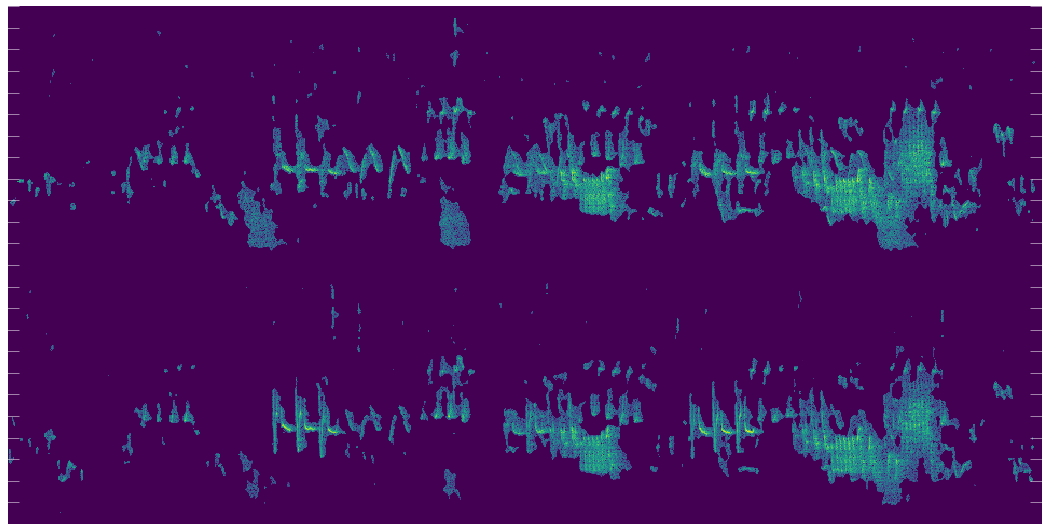

In [9]:
# figure configuration
dpi = 192
channels = sound.n_channels
fig, ax = plt.subplots(channels, 1)
fig.set_dpi(dpi)
fig.set_figwidth((920 / dpi) * 3)
fig.set_figheight((460 / dpi) * 3)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.set_frameon(False)

# specify frequency bins (width of 1 kiloherz)
bins = np.arange(0, (sound.rate / 2), 1000)

# plot spectrogram for each channel
for channel in range(channels):
    spec = ax[channel].pcolormesh(t, f, ale[channel], cmap='viridis')
    ax[channel].set(ylim=([0, sound.rate / 2]),
                  yticks = bins.astype(np.int) + 1000)
    ax[channel].tick_params(length=12, color='white',
                          bottom=False, labelbottom=False,
                          top=False, labeltop=False,
                          labelleft=False,
                          labelright=False)
    ax[channel].set_frame_on(False)

compute ACI

In [10]:
aci_ale = calculate_aci(10**(ale / 10), 
                        (t[1] - t[0]),
                        5.,
                        np.empty(shape=(ale.shape[0], ale.shape[1])))

plot the ACI

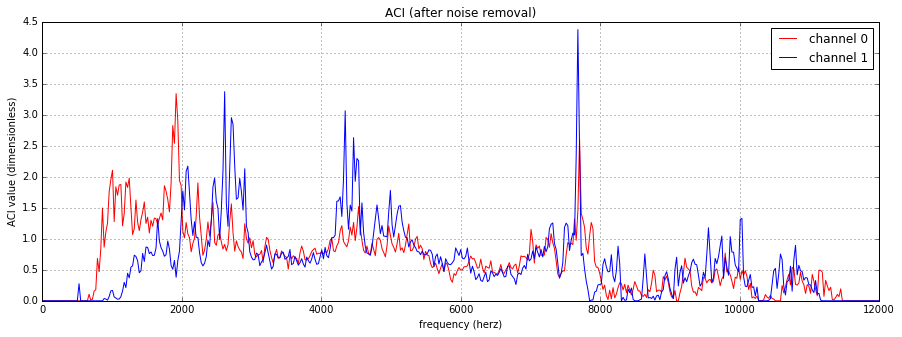

In [11]:
colors = ['red', 'blue']
fig, ax = plt.subplots(figsize=(15, 5))
for channel in range(aci.shape[0]):
    p = plt.plot(f, aci_ale[channel], color=colors[channel], 
                 label="channel {0}".format(channel))
title = ax.set_title('ACI (after noise removal)')
xlabel = ax.set_xlabel('frequency (herz)')
ylabel = ax.set_ylabel('ACI value (dimensionless)')
legend = ax.legend()
ax.grid(True, which='major')